# Feature Consistency in Latin Comedy

In [1]:
# Imports

from collections import Counter

from cltk.corpus.readers import get_corpus_reader

from pprint import pprint

In [2]:
# Get files

ll = get_corpus_reader(corpus_name = 'latin_text_latin_library', language = 'latin')
files = ll.fileids()

plautus_files = [file for file in files if 'plaut' in file]
terence_files = [file for file in files if 'ter.' in file]

print(plautus_files)
print(terence_files)

['plautus/amphitruo.txt', 'plautus/asinaria.txt', 'plautus/aulularia.txt', 'plautus/bacchides.txt', 'plautus/captivi.txt', 'plautus/cas.txt', 'plautus/cistellaria.txt', 'plautus/curculio.txt', 'plautus/epidicus.txt', 'plautus/menaechmi.txt', 'plautus/mercator.txt', 'plautus/miles.txt', 'plautus/mostellaria.txt', 'plautus/persa.txt', 'plautus/poenulus.txt', 'plautus/pseudolus.txt', 'plautus/rudens.txt', 'plautus/stichus.txt', 'plautus/trinummus.txt', 'plautus/truculentus.txt', 'plautus/vidularia.txt']
['ter.adel.txt', 'ter.andria.txt', 'ter.eunuchus.txt', 'ter.heauton.txt', 'ter.hecyra.txt', 'ter.phormio.txt']


In [3]:
# Get raw text

plautus_raws = [ll.raw(file) for file in plautus_files]
terence_raws = [ll.raw(file) for file in terence_files]

In [4]:
# Imports for preprocessing

import re # Regex module, useful for pattern matching
import html # Useful for handling entities

# Import/load a CLTK tool for normalizing i/j and u/v in Latin texts
from cltk.stem.latin.j_v import JVReplacer
replacer = JVReplacer()

In [5]:
# Preprocess texts

# I've written the following preprocessing function for today's workshop. It's
# pretty specific in a few cases—more so than I would normally would use, e.g. '8a'
# and '8b'.

# Still the goal of preprocessing is to make all of the texts we are working with
# for this experiment as uniform as possible, so that functions/processes further along
# encounter consistent data. GIGO, as they say. E.g., for today we want
# 'verbum' and 'uerbum' to be treated as the same word. For a different experiment, 
# you might not and need to make different editorial choices.

def preprocess(text):

    # Remove Latin Library-specific paratexts with regex
    
    remove_list = [r'\bThe Latin Library\b',
                   r'\bThe Classics Page\b',
                   r'\bPlautus\b',
                   r'\bTerence\b',
                   r'\b[A-Z]+\b\.',
                   r'\b[A-Z]+\b',
                  ]
    
    for pattern in remove_list:
        text = re.sub(pattern, '', text)
    
    # Remove first line
    text = text[text.find('\n'):]

    # Remove html entities and related html artifacts
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
    text = re.sub(r' \xa0 ', '    ', text)
    
#     # Remove roman numeral headings; must be before lower & replacer
#     text = re.sub(r'\b(M{1,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|C?D|D?C{1,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,4})|M{0,4}(CM|CD|D?C{0,3})(XC|X?L|L?X{1,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|I?V|V?I{1,3}))\b',' ',text)
    
    # Lowercase text
    text = text.lower()

    # Normalize text
    text = replacer.replace(text) #Normalize u/v & i/j
    
    # Remove punctuation with translate
    punctuation ="\"#$%&\'()+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    # Remove numbers
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    # Remove all space
    text = re.sub('\s+', ' ', text)
    
    return text.strip()

In [6]:
# Preprocess texts

plautus_edits = [preprocess(raw) for raw in plautus_raws]
terence_edits = [preprocess(raw) for raw in terence_raws]

In [29]:
# Get titles

plautus_titles = ['Pl. ' + file.replace('plautus/','').replace('.txt','').title() for file in plautus_files]
terence_titles = ['Ter. ' + file.replace('ter.','').replace('.txt','').title() for file in terence_files]

In [8]:
# Set up CLTK Latin word tokenizer

from cltk.tokenize.word import WordTokenizer
word_tokenizer = WordTokenizer('latin')

In [9]:
plautus_tokens = [word_tokenizer.tokenize(edit) for edit in plautus_edits]
terence_tokens = [word_tokenizer.tokenize(edit) for edit in terence_edits]

In [10]:
# Set up CLTK Latin backoff lemmatizer

from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
lemmatizer = BackoffLatinLemmatizer()

In [11]:
plautus_lemma_pairs = [lemmatizer.lemmatize(tokens) for tokens in plautus_tokens]    
terence_lemma_pairs = [lemmatizer.lemmatize(tokens) for tokens in terence_tokens]    

plautus_lemmas = [[item[1] for item in pairs] for pairs in plautus_lemma_pairs]
terence_lemmas = [[item[1] for item in pairs] for pairs in terence_lemma_pairs]

In [12]:
plautus_lemmas_flat = [y for x in plautus_lemmas for y in x]
terence_lemmas_flat = [y for x in terence_lemmas for y in x]
lemmas_flat = plautus_lemmas_flat + terence_lemmas_flat

In [13]:
plautus_lemmatized_texts = [" ".join(lemmas) for lemmas in plautus_lemmas]
terence_lemmatized_texts = [" ".join(lemmas) for lemmas in terence_lemmas]

## Plotting vector space

In [14]:
# Import modules

import numpy as np
import pandas as pd
import sklearn.feature_extraction.text as text

# Create an instance of a count vectorizer
vectorizer = text.CountVectorizer(input='content')

In [15]:
# Imports

import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
texts = plautus_lemmatized_texts + terence_lemmatized_texts
titles = plautus_titles + terence_titles

In [17]:
# Obviously for a complete work, the matrix is much larger (and more
# sparse, i.e. lots of zeroes).

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

In [18]:
# Compute Euclidean distance across the document-term matrix
dist = 1 - cosine_similarity(dtm)

# Reduce dimensionality
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)

# Get coordinates
pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

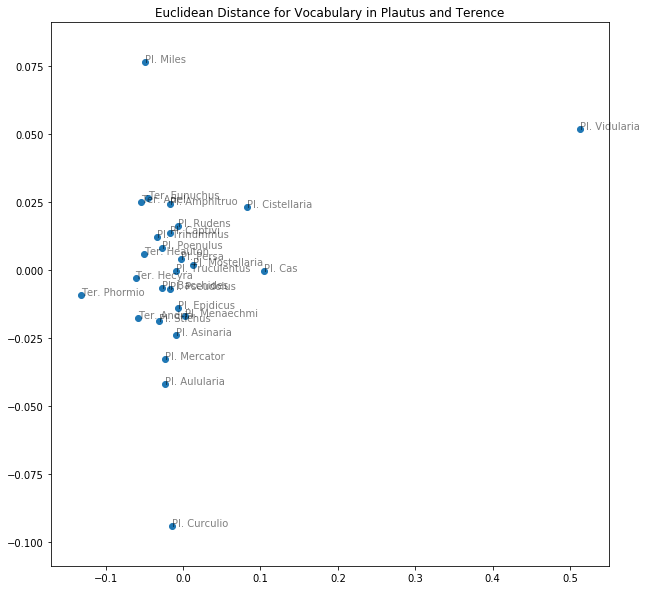

In [19]:
# Create scatterplot

plt.figure(figsize=(10,10))
plt.title('Euclidean Distance for Vocabulary in Plautus and Terence')
plt.scatter(xs, ys, cmap='spring')
for x, y, name in zip(xs, ys, titles):
    plt.text(x,y,name,alpha=0.5,fontsize=10)
plt.show()

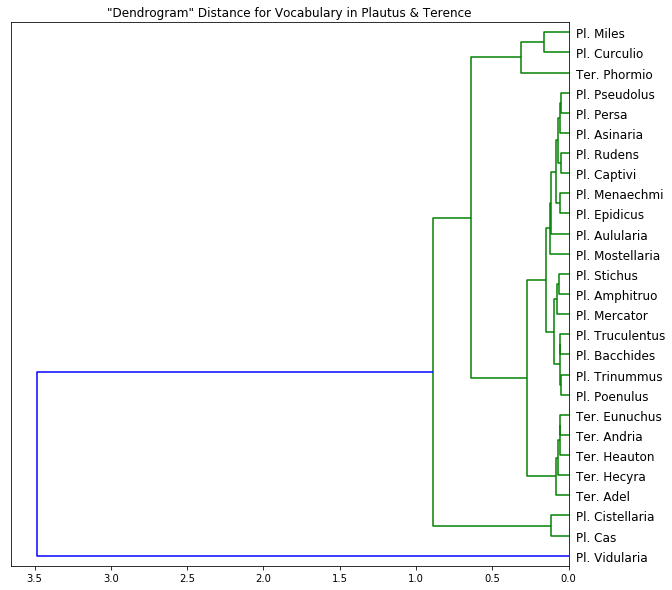

In [31]:
# We can combine our two elegists to visualize them together

from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

texts = plautus_lemmatized_texts + terence_lemmatized_texts

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()

dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist)
linkage_matrix = ward(dist)

plt.figure(figsize=(10,10))
plt.title('"Dendrogram" Distance for Vocabulary in Plautus & Terence')
dendrogram(linkage_matrix, orientation="left", labels=titles, leaf_font_size=12);
plt.show()

In [71]:
# Limit lemmas to top x lemmas
top = 25

top_lemmas = [item[0] for item in Counter(lemmas_flat).most_common(top)]

plautus_lemmas_top = [[lemma for lemma in lemmas if lemma in top_lemmas] for lemmas in plautus_lemmas]
terence_lemmas_top = [[lemma for lemma in lemmas if lemma in top_lemmas] for lemmas in terence_lemmas]

In [72]:
plautus_lemmatized_top_texts = [" ".join(lemmas) for lemmas in plautus_lemmas_top]
terence_lemmatized_top_texts = [" ".join(lemmas) for lemmas in terence_lemmas_top]

In [73]:
texts = plautus_lemmatized_top_texts + terence_lemmatized_top_texts

# Obviously for a complete work, the matrix is much larger (and more
# sparse, i.e. lots of zeroes).

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

# Compute Euclidean distance across the document-term matrix
dist = 1 - cosine_similarity(dtm)

# Reduce dimensionality
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)

# Get coordinates
pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

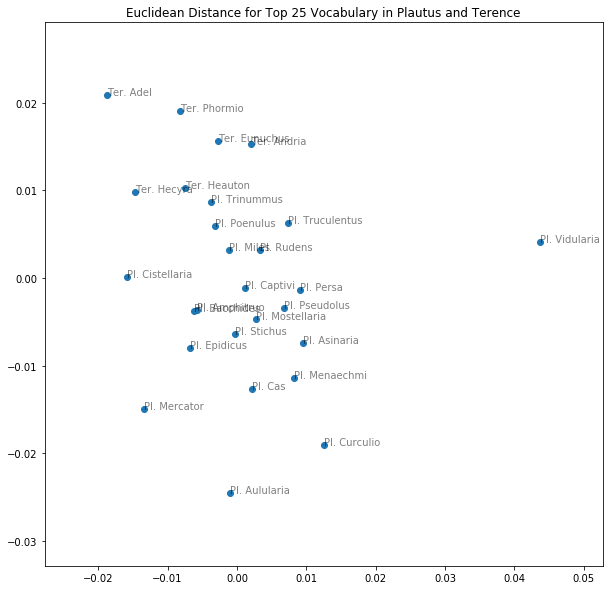

In [74]:
# Create scatterplot

plt.figure(figsize=(10,10))
plt.title(f'Euclidean Distance for Top {top} Vocabulary in Plautus and Terence')
plt.scatter(xs, ys, cmap='spring')
for x, y, name in zip(xs, ys, titles):
    plt.text(x,y,name,alpha=0.5,fontsize=10)
plt.show()

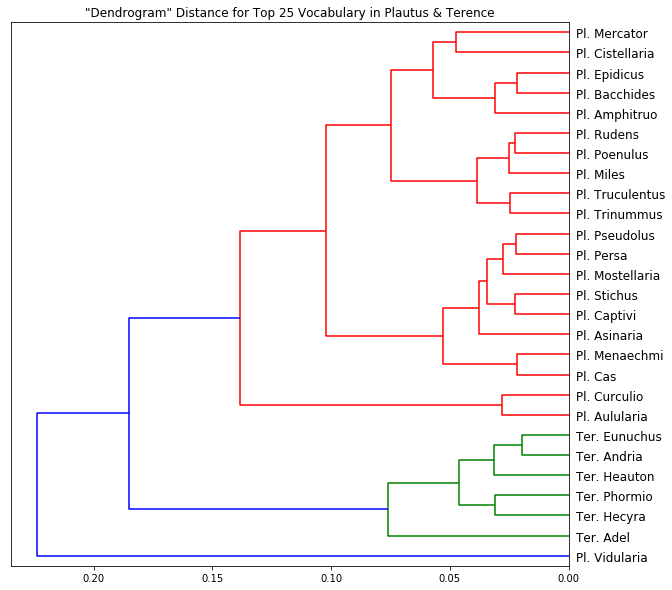

In [75]:
# We can combine our two dramatists to visualize them together

from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()

dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist)
linkage_matrix = ward(dist)

plt.figure(figsize=(10,10))
plt.title(f'"Dendrogram" Distance for Top {top} Vocabulary in Plautus & Terence')
dendrogram(linkage_matrix, orientation="left", labels=titles, leaf_font_size=12);
plt.show()

In [76]:
print(top_lemmas)

['sum', 'ego', 'tu', 'hic', 'qui', 'is', 'quis', 'ut', 'facio', 'et', 'ille', 'in', 'si', 'non', 'meus', 'do', 'cum2', 'atque', 'nunc', 'dico', 'ad', 'res', 'quam', 'uolo', 'iste']
